In [1]:
 %pip install pytorch-lightning

^C


     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/71.4 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/71.4 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/71.4 kB ? et

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
evaluate 0.4.3 requires datasets>=2.0.0, which is not installed.
evaluate 0.4.3 requires dill, which is not installed.
evaluate 0.4.3 requires huggingface-hub>=0.7.0, which is not installed.
evaluate 0.4.3 requires multiprocess, which is not installed.
evaluate 0.4.3 requires xxhash, which is not installed.
langchain 0.3.0 requires pydantic<3.0.0,>=2.7.4, which is not installed.


In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [4]:
torch.cuda.device_count()

1

In [5]:
NUM_WORKERS

10

In [10]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [11]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [12]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 14, 14]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 28, 28]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [22]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        # self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.latent_dim = latent_dim

        # random noise
        self.validation_z = torch.randn(6,self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, target):
        return F.binary_cross_entropy(y_hat, target)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # train generator: max log(D(G(z)))
        if optimizer_idx == 0:
            fake_imgs = self(z) # run forward func
            y_hat = self.discriminator(fake_imgs)

            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)

            log_dict = {"g_loss": g_loss}
            return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}    

        # train discriminator: max log(D(x)) + log(1 - D(G(z)))
        if optimizer_idx == 1:
            # how well can it label as real
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            # how well can it label as fake    
            y_hat_fake = self.discriminator(self(z).detach())
            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss) / 2

            log_dict = {"d_loss": d_loss}

            return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self):
        z =  self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ',self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation="none")
            plt.title(f"Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_epoch_end(self):
        z = self.validation_z
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
        

In [28]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.latent_dim = latent_dim

        # random noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        # 禁用自动优化
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, target):
        return F.binary_cross_entropy(y_hat, target)
    
    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # 获取两个优化器
        opt_g, opt_d = self.optimizers()

        # --- Train generator ---
        fake_imgs = self(z)  # run forward func
        y_hat = self.discriminator(fake_imgs)

        y = torch.ones(real_imgs.size(0), 1)
        y = y.type_as(real_imgs)

        g_loss = self.adversarial_loss(y_hat, y)

        # Backprop and optimize generator
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

        log_dict = {"g_loss": g_loss}

        # --- Train discriminator ---
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1)
        y_real = y_real.type_as(real_imgs)

        real_loss = self.adversarial_loss(y_hat_real, y_real)
        
        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros(real_imgs.size(0), 1)
        y_fake = y_fake.type_as(real_imgs)

        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2

        # Backprop and optimize discriminator
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        log_dict["d_loss"] = d_loss

        return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self):
        z =  self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ',self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation="none")
            plt.title(f"Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_epoch_end(self):
        z = self.validation_z
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

        # 直接显示每个epoch生成的图片
        self.plot_imgs()

In [29]:
dm = MNISTDataModule()
model = GAN()

epoch  0


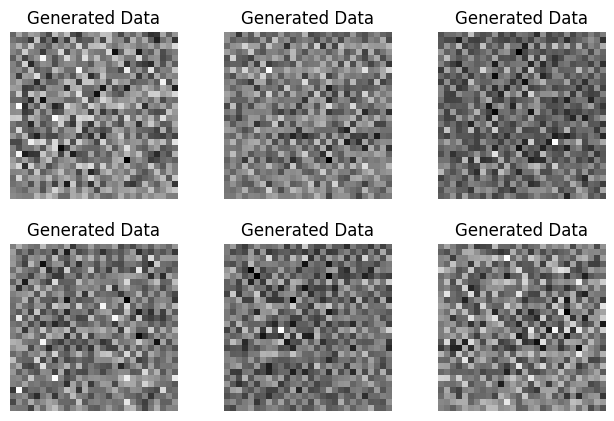

In [30]:
model.plot_imgs()

In [31]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
g:\C_pan_copy_dir\.conda\envs\torch_gpu_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   1%|          | 5/430 [00:00<01:09,  6.13it/s, v_num=2]

g:\C_pan_copy_dir\.conda\envs\torch_gpu_env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 19: 100%|██████████| 430/430 [00:25<00:00, 16.63it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 430/430 [00:25<00:00, 16.62it/s, v_num=2]
